# Kernel OT Learning for Offline Goal Conditioned RL Experiment

## Setup: Imports, Device Detection & Logger Initialization

In [1]:
import os
import sys

# ✅ CRITICAL: Set single GPU before importing torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Only use GPU 0
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime

# Add paths
sys.path.insert(0, '/data1/sandesh/COT/Kernel_OT_for_OGRL')
sys.path.insert(0, '/data1/sandesh/COT')

# Import custom modules
from data_prep import DataPreparator
from kernels import IMQKernel
from losses import PairedLoss, TerminalLoss, CombinedLoss
from models import TransitionModel
from train import Trainer, TransitionDataset
from evaluate import Evaluator
from models_advanced.policy_aq_model import PolicyAugmentedTransitionModel

# ✅ GPU Memory Optimization Setup
try:
    if torch.cuda.is_available():
        # Clear any cached memory first
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        
        DEVICE = torch.device("cuda:0")
        print(f"✓ GPU Available: {torch.cuda.get_device_name(0)}")
        print(f"  CUDA Device Count: {torch.cuda.device_count()}")
        print(f"  CUDA Capability: {torch.cuda.get_device_capability(0)}")
        
        # ✅ Memory Optimization Settings
        torch.cuda.set_per_process_memory_fraction(0.9)  # Max 90% of GPU memory
        torch.backends.cuda.matmul.allow_tf32 = True  # Speed up without extra memory
        
        print(f"✓ GPU Memory Optimization ENABLED:")
        print(f"  - Single GPU only (GPU 0)")
        print(f"  - Per-process memory fraction: 90%")
        print(f"  - TF32 precision: ENABLED")
        
    else:
        DEVICE = torch.device("cpu")
        print(f"⚠ GPU Not available - using CPU (PyTorch version: {torch.__version__})")
except Exception as e:
    print(f"✗ CUDA check failed: {e}")
    DEVICE = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {DEVICE}")

# Create output directory
OUTPUT_DIR = "/data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Logger class
class ExperimentLogger:
    def __init__(self, output_dir, filename="experiment_log.txt"):
        self.output_dir = output_dir
        self.log_path = os.path.join(output_dir, filename)
        
    def log(self, message):
        """Log to both console and file"""
        print(message)
        with open(self.log_path, 'a') as f:
            f.write(message + "\n")
    
    def log_dict(self, title, data_dict):
        """Log a dictionary with title"""
        self.log(f"\n{title}:")
        for key, val in data_dict.items():
            self.log(f"  {key}: {val}")

# Initialize logger
logger = ExperimentLogger(OUTPUT_DIR)
logger.log(f"\n{'='*80}")
logger.log(f"Kernel OT Learning for Offline Goal Conditioned RL")
logger.log(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
logger.log(f"{'='*80}")
logger.log(f"✓ Device: {DEVICE}")
logger.log(f"✓ Output directory: {OUTPUT_DIR}")

print("\n✓ Setup complete!")

✓ GPU Available: NVIDIA A40
  CUDA Device Count: 1
  CUDA Capability: (8, 6)
✓ GPU Memory Optimization ENABLED:
  - Single GPU only (GPU 0)
  - Per-process memory fraction: 90%
  - TF32 precision: ENABLED
PyTorch version: 2.7.1+cu118
Device: cuda:0

Kernel OT Learning for Offline Goal Conditioned RL
Start time: 2025-11-13 14:26:54
✓ Device: cuda:0
✓ Output directory: /data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs

✓ Setup complete!


In [2]:

# ============================================================================
# Weights & Biases Setup
# ============================================================================

# Install wandb if not already installed
import subprocess
import sys

try:
    import wandb
    print(f"✓ wandb already installed (version: {wandb.__version__})")
except ImportError:
    print("Installing wandb...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wandb", "-q"])
    import wandb
    print(f"✓ wandb installed (version: {wandb.__version__})")

# Wandb login with API key
WANDB_API_KEY = "e6e318645396146a7688038762f84549eba42ccc"

try:
    # Try to login silently
    wandb.login(key=WANDB_API_KEY, relogin=False)
    print(f"✓ Weights & Biases logged in successfully!")
    print(f"  User: {wandb.api.default_user()}")
except Exception as e:
    print(f"⚠️  wandb login error: {e}")
    print("Attempting interactive login...")
    wandb.login(key=WANDB_API_KEY, relogin=True)

# Store wandb state globally
WANDB_ENABLED = True
WANDB_RUN = None

logger.log("✓ Weights & Biases setup complete!")
print("✓ W&B setup complete - ready for training runs!")


/data1/sandesh/anaconda3/envs/kernel-ot-env/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/data1/sandesh/anaconda3/envs/kernel-ot-env/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may

✓ wandb already installed (version: 0.22.0)


wandb: Currently logged in as: sandeshkatakam to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data1/sandesh/.netrc


✓ Weights & Biases logged in successfully!
⚠️  wandb login error: 'Api' object has no attribute 'default_user'
Attempting interactive login...
✓ Weights & Biases setup complete!
✓ W&B setup complete - ready for training runs!


## Config Loading


In [4]:
logger.log("\n[Step 1] Configuration Loading")
logger.log("="*80)

# Load or create configuration
config_path = "/data1/sandesh/COT/config.yaml"

# Phase 2: Improved Terminal Loss with Kernel Embedding Matching
# UPDATES: Increased n_rollout_samples to 5 for better stochasticity
#          Increased lambda_terminal to 1.5 for stronger goal-reaching incentive
#          Increased epochs to 15 for better convergence observation
config = {
    'environment': 'antmaze-large-navigate-v0',
    'env_name': 'antmaze-large-navigate-v0',
    'num_goal_states': 1,  # Single fixed goal state
    'num_transitions': 100000,  # Number of transitions to load
    'num_epochs': 5,  # ← INCREASED from 10: More epochs to observe convergence
    'batch_size': 32,  # Smaller batches for stability
    'training': {
        'learning_rate': 0.0001,  # Low LR to prevent gradient explosion
        'num_epochs': 15,
    },
    'loss': {
        'lambda_paired': 0.0,
        'lambda_terminal': 1.0,  # ← INCREASED from 1.0: Terminal loss more important
    },
    'sampling': {
        'm': 3,  # Samples per state for paired loss
        'T': 10,  # Rollout horizon
        'n_rollout_samples': 3,  # ← INCREASED from 2: Multiple independent rollouts
    },
    'seed': 42,
    'device': DEVICE,
    'transition_data_save_path': 'transition_data.pt',
    'goal_state_save_path': 'goal_states.pt',
    'checkpoint_dir': os.path.join('/data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs', 'checkpoints_phase2'),
}

# Set random seed
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])

# Create checkpoint directory for per-epoch saves
checkpoint_dir = config['checkpoint_dir']
os.makedirs(checkpoint_dir, exist_ok=True)

logger.log("✓ Configuration loaded (Phase 2: Terminal Loss with Embedding Matching)")
logger.log_dict("Config - Phase 2 Updates", {
    'env': config['env_name'],
    'epochs': config['num_epochs'],
    'batch_size': config['batch_size'],
    'learning_rate': config['training']['learning_rate'],
    'lambda_paired': config['loss']['lambda_paired'],
    'lambda_terminal': config['loss']['lambda_terminal'],
    'rollout_horizon_T': config['sampling']['T'],
    'n_rollout_samples': config['sampling']['n_rollout_samples'],
    'terminal_loss_type': 'Kernel Embedding Matching (Vectorized)',
    'gradient_clip_norm': 0.5,
    'gradient_clip_value': 0.1,
})
logger.log(f"✓ Checkpoint directory: {checkpoint_dir}")

SEED = config['seed']
print(f"✓ Configuration ready (Phase 2)!")


[Step 1] Configuration Loading
✓ Configuration loaded (Phase 2: Terminal Loss with Embedding Matching)

Config - Phase 2 Updates:
  env: antmaze-large-navigate-v0
  epochs: 5
  batch_size: 32
  learning_rate: 0.0001
  lambda_paired: 0.0
  lambda_terminal: 1.0
  rollout_horizon_T: 10
  n_rollout_samples: 3
  terminal_loss_type: Kernel Embedding Matching (Vectorized)
  gradient_clip_norm: 0.5
  gradient_clip_value: 0.1
✓ Checkpoint directory: /data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs/checkpoints_phase2
✓ Configuration ready (Phase 2)!


## Step 2: Data Loading from D4RL Ant-Maze

In [5]:
logger.log("\n[Step 2] Data Loading")
logger.log("="*80)

# Load data using DataPreparator
preparator = DataPreparator(config)
transition_data, goal_states_prepared = preparator.prepare_data()

logger.log(f"✓ Data loaded from {config['env_name']}")
logger.log_dict("Transition Data", {
    'states_shape': str(transition_data['s'].shape),
    'next_states_shape': str(transition_data['s_next'].shape),
})

# Extract state dimension and goal state
s_all = transition_data['s'].cpu().float() if transition_data['s'].is_cuda else transition_data['s'].float()
s_next_all = transition_data['s_next'].cpu().float() if transition_data['s_next'].is_cuda else transition_data['s_next'].float()
STATE_DIM = s_all.shape[1]

# Extract single fixed goal state from prepared goal states
GOAL_STATE = goal_states_prepared[0].cpu().float() if goal_states_prepared[0].is_cuda else goal_states_prepared[0].float()
logger.log(f"✓ Goal state extracted (state_dim={STATE_DIM})")

# Train/val split
split_idx = int(0.8 * len(s_all))
s_train = s_all[:split_idx]
s_next_train = s_next_all[:split_idx]
s_val = s_all[split_idx:]
s_next_val = s_next_all[split_idx:]

# Create datasets
train_transition_data = {
    's': s_train.numpy(),
    's_next': s_next_train.numpy(),
}
val_transition_data = {
    's': s_val.numpy(),
    's_next': s_next_val.numpy(),
}

train_dataset = TransitionDataset(train_transition_data, goal_states=GOAL_STATE.unsqueeze(0))
val_dataset = TransitionDataset(val_transition_data, goal_states=GOAL_STATE.unsqueeze(0))

# Create dataloaders
batch_size = config['batch_size']
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

logger.log(f"\n✓ Data split: train={len(s_train)}, val={len(s_val)}")
logger.log(f"✓ Dataloaders created (batch_size={batch_size})")

print(f"✓ Data loading complete!")


[Step 2] Data Loading
DATA PREPARATION

[1/3] Loading antmaze-large-navigate-v0 environment...
✓ Environment loaded

[2/3] Extracting transition pairs...
  • Extracted 100000 transition pairs
  • State shape: torch.Size([100000, 29])
  • State range: [-8.225, 37.310]

[3/3] Selecting fixed goal states...
  • Selected 1 goal states
  • Goal shape: torch.Size([1, 29])
  • Goal range: [-4.110, 8.378]

DATA PREPARATION COMPLETE
✓ Data loaded from antmaze-large-navigate-v0

Transition Data:
  states_shape: torch.Size([100000, 29])
  next_states_shape: torch.Size([100000, 29])
✓ Goal state extracted (state_dim=29)

✓ Data split: train=80000, val=20000
✓ Dataloaders created (batch_size=32)
✓ Data loading complete!


## Step 3: Model Initialization (Kernel + Policy-Augmented)

In [6]:
logger.log("\n[Step 3] Model Initialization")
logger.log("="*80)

# Reload modules to pick up latest changes
import importlib
import sys
if 'models_advanced.policy_aq_model' in sys.modules:
    del sys.modules['models_advanced.policy_aq_model']
if 'models_advanced.maf_utils' in sys.modules:
    del sys.modules['models_advanced.maf_utils']
if 'models_advanced.mdn_utils' in sys.modules:
    del sys.modules['models_advanced.mdn_utils']

from models_advanced.policy_aq_model import PolicyAugmentedTransitionModel

# Initialize IMQ Kernel (fixed, non-learnable)
kernel = IMQKernel(alpha=1.0)
logger.log("✓ IMQ Kernel initialized (α=1.0, fixed)")

# Initialize PolicyAugmentedTransitionModel with MAF checkpoint
maf_ckpt_path = "/data1/sandesh/COT/OTFlowRL/ckpt_maf/best.pt"
n_components = 5
hidden_dim = 256

logger.log(f"\nInitializing PolicyAugmentedTransitionModel...")
logger.log(f"  State dim: {STATE_DIM}")
logger.log(f"  Action dim: 8")
logger.log(f"  MDN components: {n_components}")
logger.log(f"  Hidden dim: {hidden_dim}")
logger.log(f"  MAF checkpoint: {maf_ckpt_path}")

transition_model = PolicyAugmentedTransitionModel(
    state_dim=STATE_DIM,
    action_dim=8,
    policy_ckpt=maf_ckpt_path,
    n_components=n_components,
    hidden_dim=hidden_dim,
    device=DEVICE
)

# Move model to device (GPU support)
transition_model = transition_model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in transition_model.parameters())
learnable_params = sum(p.numel() for p in transition_model.parameters() if p.requires_grad)

logger.log(f"\n✓ PolicyAugmentedTransitionModel initialized")
logger.log_dict("Model Parameters", {
    'Total': total_params,
    'Learnable': learnable_params,
    'Device': str(DEVICE),
})

print(f"✓ Model initialization complete!")


[Step 3] Model Initialization
✓ IMQ Kernel initialized (α=1.0, fixed)

Initializing PolicyAugmentedTransitionModel...
  State dim: 29
  Action dim: 8
  MDN components: 5
  Hidden dim: 256
  MAF checkpoint: /data1/sandesh/COT/OTFlowRL/ckpt_maf/best.pt
✓ Loaded pretrained policy from /data1/sandesh/COT/OTFlowRL/ckpt_maf/best.pt (model key)

✓ PolicyAugmentedTransitionModel initialized

Model Parameters:
  Total: 3088021
  Learnable: 738837
  Device: cuda:0
✓ Model initialization complete!


## Step 4: Loss Functions and Trainer Setup

In [7]:
logger.log("\n[Step 4] Loss Functions and Trainer")
logger.log("="*80)

lambda_paired = config['loss']['lambda_paired']
lambda_terminal = config['loss']['lambda_terminal']

# Create combined loss function
loss_fn = CombinedLoss(
    kernel=kernel,
    config=config
)
logger.log("✓ CombinedLoss initialized")
logger.log_dict("Loss Configuration", {
    'lambda_paired': lambda_paired,
    'lambda_terminal': lambda_terminal,
    'Paired loss weight': lambda_paired,
    'Terminal loss weight': lambda_terminal,
    'Rollout horizon T': config['sampling']['T'],
})

# Initialize trainer with optimizer
trainer = Trainer(
    model=transition_model,
    kernel=kernel,
    loss_fn=loss_fn,
    config=config,
    device=DEVICE
)
logger.log("✓ Trainer initialized")
logger.log_dict("Trainer Configuration", {
    'Optimizer': 'Adam',
    'Learning rate': config['training']['learning_rate'],
    'Device': str(DEVICE),
})

# Training history storage
training_history = {
    'train_loss': [],
    'val_loss': [],
    'train_loss_paired': [],
    'train_loss_terminal': [],
    'val_loss_paired': [],
}

logger.log("\n✓ Loss and trainer setup complete!")
print(f"✓ Loss and trainer ready!")


[Step 4] Loss Functions and Trainer
✓ CombinedLoss initialized

Loss Configuration:
  lambda_paired: 0.0
  lambda_terminal: 1.0
  Paired loss weight: 0.0
  Terminal loss weight: 1.0
  Rollout horizon T: 10
✓ Trainer initialized

Trainer Configuration:
  Optimizer: Adam
  Learning rate: 0.0001
  Device: cuda:0

✓ Loss and trainer setup complete!
✓ Loss and trainer ready!


In [9]:

# ============================================================================
# WANDB RUN CONFIGURATION - Interactive Setup
# ============================================================================

logger.log("\n[Step 4.5] Weights & Biases - Interactive Run Configuration")
logger.log("="*80)

# Collect run metadata from user
print("\n" + "="*80)
print("WEIGHTS & BIASES - TRAINING RUN CONFIGURATION")
print("="*80)

# Get run name (required)
run_name = input("\n📝 Enter training run name (e.g., 'exp_v1_terminal_loss_opt'): ").strip()
if not run_name:
    run_name = f"kernel_ot_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    print(f"   Using default: {run_name}")

# Get run description
run_description = input("📝 Enter run description (optional): ").strip()
if not run_description:
    run_description = "Kernel OT training with policy-augmented transition model"

# Get tags
tags_input = input("📝 Enter tags (comma-separated, optional): ").strip()
tags = [tag.strip() for tag in tags_input.split(',')] if tags_input else ['kernel-ot', 'phase-3-optimized']

# Get notes
notes = input("📝 Enter additional notes (optional): ").strip()

# Display configuration
print("\n" + "-"*80)
print("WANDB RUN CONFIGURATION:")
print("-"*80)
print(f"Run Name:     {run_name}")
print(f"Description:  {run_description}")
print(f"Tags:         {', '.join(tags)}")
print(f"Notes:        {notes if notes else '(none)'}")
print(f"Project:      kernel-ot-learning")
# WITH THIS:
try:
    wandb_user = wandb.api.viewer()["entity"]
except:
    wandb_user = "unknown"
print(f"Entity:       {wandb_user}")
# print(f"Entity:       {wandb.api.default_user()}")
print("-"*80)

# Initialize wandb run
try:
    WANDB_RUN = wandb.init(
        project="kernel-ot-learning",
        name=run_name,
        tags=tags,
        notes=notes,
        config={
            'architecture': 'PolicyAugmentedTransitionModel',
            'epochs': config['num_epochs'],
            'batch_size': config['batch_size'],
            'learning_rate': config['training']['learning_rate'],
            'lambda_paired': config['loss']['lambda_paired'],
            'lambda_terminal': config['loss']['lambda_terminal'],
            'rollout_horizon_T': config['sampling']['T'],
            'n_rollout_samples': config['sampling']['n_rollout_samples'],
            'kernel_type': 'IMQKernel',
            'device': str(DEVICE),
        },
        
    )
    
    print(f"\n✓ Weights & Biases run initialized!")
    print(f"  Project: {WANDB_RUN.project_name}")
    print(f"  Run ID: {WANDB_RUN.id}")
    print(f"  Run URL: {WANDB_RUN.get_url()}")
    
    logger.log(f"✓ W&B Run initialized: {run_name}")
    logger.log(f"  Run URL: {WANDB_RUN.get_url()}")
    
except Exception as e:
    print(f"⚠️  Error initializing W&B run: {e}")
    WANDB_RUN = None
    logger.log(f"⚠️  W&B initialization failed: {e}")

print("\n✓ W&B configuration complete!")



[Step 4.5] Weights & Biases - Interactive Run Configuration

WEIGHTS & BIASES - TRAINING RUN CONFIGURATION



--------------------------------------------------------------------------------
WANDB RUN CONFIGURATION:
--------------------------------------------------------------------------------
Run Name:     kernel-ot-ogrl-terminal-loss-only
Description:  Kernel OT training with policy-augmented transition model
Tags:         kernel-ot, phase-3-optimized
Notes:        (none)
Project:      kernel-ot-learning
Entity:       sandeshkatakam
--------------------------------------------------------------------------------
Entity:       sandeshkatakam
--------------------------------------------------------------------------------


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.



✓ Weights & Biases run initialized!
  Project: <bound method Run.project_name of <wandb.sdk.wandb_run.Run object at 0x7f849884d750>>
  Run ID: cpi8rrdj
  Run URL: https://wandb.ai/sandeshkatakam/kernel-ot-learning/runs/cpi8rrdj
✓ W&B Run initialized: kernel-ot-ogrl-terminal-loss-only
  Run URL: https://wandb.ai/sandeshkatakam/kernel-ot-learning/runs/cpi8rrdj

✓ W&B configuration complete!


In [ ]:
logger.log("\n[Step 5] SINGLE-GPU Training Loop (Terminal Loss Only)")
logger.log("="*80)
logger.log("⚠️  IMPORTANT: TERMINAL LOSS ONLY - NO paired loss")
logger.log("   Lambda_paired = 0.0 (disabled)")
logger.log("   Lambda_terminal = 1.0 (enabled)")
logger.log("="*80)

num_epochs = config['num_epochs']
best_val_loss = float('inf')
best_model_path = os.path.join(OUTPUT_DIR, "policy_augmented_transition_kernel_best_terminal_only.pt")

# Gradient monitoring
max_grad_norms = []
mean_grad_norms = []
terminal_loss_tracker = []

for epoch in range(num_epochs):
    # Training phase
    transition_model.train()
    epoch_train_loss = 0.0
    epoch_train_loss_terminal = 0.0
    num_batches = 0
    epoch_grad_norms = []
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", disable=False)
    
    for batch_idx, (s_batch, s_next_batch) in enumerate(pbar):
        # Move to device
        s_batch = s_batch.to(DEVICE)
        s_next_batch = s_next_batch.to(DEVICE)
        goal_states_batch = train_dataset.goal_states.to(DEVICE)
        
        # ✅ ONLY compute terminal loss (paired loss disabled)
        use_terminal_loss = True
        
        try:
            loss_total, loss_dict = loss_fn(
                transition_model, 
                s_batch, 
                s_next_batch, 
                s_batch,
                goal_states_batch,
                use_terminal=use_terminal_loss,
                device=DEVICE
            )
        except Exception as e:
            logger.log(f"❌ ERROR in loss computation (Epoch {epoch+1}, Batch {batch_idx}): {str(e)}")
            raise
        
        # Check for NaN/Inf
        if torch.isnan(loss_total) or torch.isinf(loss_total):
            logger.log(f"❌ ERROR: Loss is NaN/Inf at Epoch {epoch+1}, Batch {batch_idx}")
            logger.log(f"   Terminal: {loss_dict.get('terminal_loss', 0.0)}")
            raise ValueError("Loss is NaN/Inf - training unstable!")
        
        # Backward pass
        trainer.optimizer.zero_grad()
        loss_total.backward()
        
        # Gradient clipping
        grad_norm = torch.nn.utils.clip_grad_norm_(transition_model.parameters(), max_norm=0.5)
        epoch_grad_norms.append(grad_norm.item())
        torch.nn.utils.clip_grad_value_(transition_model.parameters(), clip_value=0.1)
        
        if grad_norm > 1.0:
            logger.log(f"⚠ WARNING Epoch {epoch+1}, Batch {batch_idx}: High gradient norm {grad_norm:.4f}")
        
        trainer.optimizer.step()
        
        # Extract loss values
        loss_terminal_val = loss_dict.get('terminal_loss', 0.0)
        loss_total_val = loss_total.item()
        grad_norm_val = grad_norm.item()
        
        epoch_train_loss += loss_total_val
        epoch_train_loss_terminal += loss_terminal_val
        num_batches += 1
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{loss_total_val:.4f}",
            'terminal': f"{loss_terminal_val:.4f}",
            'grad_norm': f"{grad_norm_val:.4f}"
        })
        
        # ✅ Log to wandb every batch
        if WANDB_RUN is not None:
            wandb.log({
                'batch': (epoch * len(train_loader)) + batch_idx,
                'epoch': epoch + 1,
                'train/loss_total': loss_total_val,
                'train/loss_terminal': loss_terminal_val,
                'train/gradient_norm': grad_norm_val,
                'train/learning_rate': config['training']['learning_rate'],
            })
        
        # Log terminal loss periodically
        if batch_idx == 0 or (batch_idx + 1) % 500 == 0:
            logger.log(f"[Epoch {epoch+1}, Batch {batch_idx+1}] Terminal Loss: {loss_terminal_val:.6f}")
        
        # ✅ Clear GPU memory every 10 batches to prevent fragmentation
        if (batch_idx + 1) % 10 == 0:
            torch.cuda.empty_cache()
        
        
    
    # Average losses
    epoch_train_loss /= num_batches
    epoch_train_loss_terminal /= max(1, num_batches)
    
    # ✅ Clear GPU memory after training phase
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    
    # Gradient statistics
    max_grad_norm = max(epoch_grad_norms) if epoch_grad_norms else 0.0
    mean_grad_norm = np.mean(epoch_grad_norms) if epoch_grad_norms else 0.0
    max_grad_norms.append(max_grad_norm)
    mean_grad_norms.append(mean_grad_norm)
    terminal_loss_tracker.append(epoch_train_loss_terminal)
    
    # ✅ Validation phase (terminal loss only)
    transition_model.eval()
    val_loss_total = 0.0
    val_loss_terminal = 0.0
    num_val_batches = 0
    
    with torch.no_grad():
        for s_val, s_next_val in val_loader:
            s_val = s_val.to(DEVICE)
            s_next_val = s_next_val.to(DEVICE)
            goal_states_val = val_dataset.goal_states.to(DEVICE)
            
            loss_val_total, loss_val_dict = loss_fn(
                transition_model,
                s_val,
                s_next_val,
                s_val,
                goal_states_val,
                use_terminal=True,
                device=DEVICE
            )
            
            val_loss_total += loss_val_total.item()
            val_loss_terminal += loss_val_dict.get('terminal_loss', 0.0)
            num_val_batches += 1
    
    # Average validation losses
    val_loss_total /= max(1, num_val_batches)
    val_loss_terminal /= max(1, num_val_batches)
    
    # ✅ Clear GPU memory after validation phase
    torch.cuda.empty_cache()
    
    # Save best model
    if val_loss_total < best_val_loss:
        best_val_loss = val_loss_total
        torch.save(transition_model.state_dict(), best_model_path)
        logger.log(f"✓ Saved best model at epoch {epoch+1} (val_loss={val_loss_total:.6f})")
    
    # Store training history
    training_history['train_loss'].append(epoch_train_loss)
    training_history['val_loss'].append(val_loss_total)
    training_history['train_loss_terminal'].append(epoch_train_loss_terminal)
    
    # ✅ Log epoch metrics to wandb
    if WANDB_RUN is not None:
        wandb.log({
            'epoch': epoch + 1,
            'train/loss_total_avg': epoch_train_loss,
            'train/loss_terminal_avg': epoch_train_loss_terminal,
            'val/loss_total': val_loss_total,
            'val/loss_terminal': val_loss_terminal,
            'train/gradient_max': max_grad_norm,
            'train/gradient_mean': mean_grad_norm,
        })
    
    # Epoch summary
    logger.log(f"\n[Epoch {epoch+1}/{num_epochs}] Training Summary:")
    logger.log(f"  Train Loss (terminal only): {epoch_train_loss:.6f}")
    logger.log(f"  Val Loss (terminal only): {val_loss_total:.6f}")
    logger.log(f"  Gradient (max: {max_grad_norm:.6f}, mean: {mean_grad_norm:.6f})")
    
    # Check terminal loss progression
    if epoch > 0:
        prev_terminal = training_history['train_loss_terminal'][-2]
        curr_terminal = training_history['train_loss_terminal'][-1]
        if abs(prev_terminal - curr_terminal) < 1e-6:
            logger.log(f"  ⚠️  Terminal loss not changing! Previous: {prev_terminal:.6f}, Current: {curr_terminal:.6f}")

logger.log("\n" + "="*80)
logger.log("✓ Training Complete!")
logger.log("="*80)


[Step 5] SINGLE-GPU Training Loop (Terminal Loss Only)
⚠️  IMPORTANT: TERMINAL LOSS ONLY - NO paired loss
   Lambda_paired = 0.0 (disabled)
   Lambda_terminal = 1.0 (enabled)


Epoch 1/5 [Train]:   0%|                                                                         | 0/2500 [00:00<?, ?it/s]

Epoch 1/5 [Train]:   0%|              | 1/2500 [00:14<10:12:06, 14.70s/it, loss=0.9848, terminal=0.9848, grad_norm=0.0023]

[Epoch 1, Batch 1] Terminal Loss: 0.984846


## W&B Summary

In [ ]:
# ============================================================================
# WANDB FINALIZATION - Save Summary & Model Artifacts
# ============================================================================

logger.log("\n[Step 5.5] Weights & Biases - Training Summary & Artifacts")
logger.log("="*80)

if WANDB_RUN is not None:
    try:
        # Calculate final metrics
        initial_terminal_loss = training_history['train_loss_terminal'][0]
        final_terminal_loss = training_history['train_loss_terminal'][-1]
        best_val_idx = np.argmin(training_history['val_loss'])
        best_val_loss_final = training_history['val_loss'][best_val_idx]
        
        # Log summary metrics
        wandb.log({
            'final/train_loss': training_history['train_loss'][-1],
            'final/best_val_loss': best_val_loss_final,
            'final/best_epoch': best_val_idx + 1,
            'final/terminal_loss': final_terminal_loss,
            'metrics/terminal_loss_reduction': (1 - final_terminal_loss / max(initial_terminal_loss, 1e-8)) * 100,
        })
        
        # Save best model to wandb artifacts
        logger.log(f"✓ Saving best model to W&B artifacts...")
        artifact = wandb.Artifact('model-best-terminal-only', type='model')
        artifact.add_file(best_model_path, name='best_model.pt')
        WANDB_RUN.log_artifact(artifact)
        
        # Create and log training curves
        logger.log(f"✓ Creating training curves for W&B...")
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Total loss
        ax = axes[0]
        ax.plot(training_history['train_loss'], 'o-', label='Train', linewidth=2, markersize=5)
        ax.plot(training_history['val_loss'], 's-', label='Val', linewidth=2, markersize=5)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Total Loss (Terminal Loss Only)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Terminal loss only
        ax = axes[1]
        ax.plot(training_history['train_loss_terminal'], 'o-', label='Train Terminal', linewidth=2, markersize=5)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Terminal Loss')
        ax.set_title('Terminal Loss Progression')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        wandb.log({"training_curves": wandb.Image(fig)})
        plt.close()
        
        logger.log(f"✓ Training curves logged to W&B!")
        
        # Finish the run
        WANDB_RUN.finish()
        logger.log(f"\n✓ W&B run finished successfully!")
        logger.log(f"  View results: {WANDB_RUN.get_url()}")
        
    except Exception as e:
        logger.log(f"⚠️  Error finalizing W&B run: {e}")
else:
    logger.log("⚠️  W&B not initialized - skipping artifact logging")

logger.log("="*80)
print("\n✓ Training and W&B logging complete!")

In [8]:
"""
Diagnostic Cell: Trajectory Validity Check After Training
- Check for out-of-bounds states
- Validate trajectory quality before evaluation
- Detect if model is generating invalid/diverging states
"""
best_model_path = "/data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs/checkpoints_phase2/model_epoch_05.pt"
logger.log("\n" + "="*80)
logger.log("[Diagnostic] Trajectory Validity Check")
logger.log("="*80)

# Load best model for trajectory generation
transition_model.load_state_dict(torch.load(best_model_path))
transition_model.eval()

# Get actual maze bounds from data
xy_train = s_train[:, :2].numpy()
x_min, x_max = xy_train[:, 0].min(), xy_train[:, 0].max()
y_min, y_max = xy_train[:, 1].min(), xy_train[:, 1].max()

logger.log(f"\n✓ Valid Maze Bounds (from dataset):")
logger.log(f"  X: [{x_min:.2f}, {x_max:.2f}] (range: {x_max - x_min:.2f})")
logger.log(f"  Y: [{y_min:.2f}, {y_max:.2f}] (range: {y_max - y_min:.2f})")

# Generate trajectories for validation check
num_diagnostic_trajectories = 5
rollout_T = config['sampling']['T']  # Use same T as loss computation

logger.log(f"\nGenerating {num_diagnostic_trajectories} diagnostic trajectories (T={rollout_T})...")

diagnostic_trajectories = []
oob_count = 0
oob_details = []

with torch.no_grad():
    for traj_idx in range(num_diagnostic_trajectories):
        # Random initial state
        idx = np.random.randint(0, len(s_train))
        s_init = s_train[idx].unsqueeze(0).to(DEVICE)
        
        trajectory = [s_init.squeeze(0).cpu().numpy()]
        s_current = s_init
        
        # Rollout for T steps
        for step in range(rollout_T):
            s_next_samples = transition_model.forward(s_current, n_samples=1)
            s_current = s_next_samples.squeeze(1)
            state_np = s_current.squeeze(0).cpu().numpy()
            trajectory.append(state_np)
            
            # Check bounds
            x, y = state_np[0], state_np[1]
            if not (x_min - 2 <= x <= x_max + 2) or not (y_min - 2 <= y <= y_max + 2):
                oob_count += 1
                oob_details.append({
                    'traj_idx': traj_idx,
                    'step': step,
                    'x': x,
                    'y': y,
                    'dist_from_bounds': max(x_min - x, x - x_max, y_min - y, y - y_max, 0)
                })
        
        diagnostic_trajectories.append(np.array(trajectory))

logger.log(f"✓ Generated {len(diagnostic_trajectories)} diagnostic trajectories")

# Validity check
if oob_count > 0:
    logger.log(f"\n❌ PROBLEM: {oob_count} out-of-bounds states detected!")
    logger.log(f"\nFirst 5 OOB violations:")
    for detail in oob_details[:5]:
        logger.log(f"  Traj {detail['traj_idx']}, Step {detail['step']}: ({detail['x']:.2f}, {detail['y']:.2f}) - dist={detail['dist_from_bounds']:.2f}")
    logger.log(f"\n⚠ Model is generating out-of-distribution states!")
    logger.log(f"⚠ Possible causes:")
    logger.log(f"   1. Terminal loss not strong enough (increase lambda_terminal)")
    logger.log(f"   2. Training instability (check gradient clipping)")
    logger.log(f"   3. Need more training epochs")
else:
    logger.log(f"\n✓ All trajectories in-bounds - model is stable!")

# State statistics
all_diag_states = np.concatenate(diagnostic_trajectories, axis=0)
data_xy = xy_train

logger.log(f"\n✓ State Distribution Statistics:")
logger.log(f"\nGenerated Trajectories:")
logger.log(f"  Mean: ({all_diag_states[:, 0].mean():.2f}, {all_diag_states[:, 1].mean():.2f})")
logger.log(f"  Std:  ({all_diag_states[:, 0].std():.2f}, {all_diag_states[:, 1].std():.2f})")
logger.log(f"  Min:  ({all_diag_states[:, 0].min():.2f}, {all_diag_states[:, 1].min():.2f})")
logger.log(f"  Max:  ({all_diag_states[:, 0].max():.2f}, {all_diag_states[:, 1].max():.2f})")

logger.log(f"\nDataset Transitions:")
logger.log(f"  Mean: ({data_xy[:, 0].mean():.2f}, {data_xy[:, 1].mean():.2f})")
logger.log(f"  Std:  ({data_xy[:, 0].std():.2f}, {data_xy[:, 1].std():.2f})")
logger.log(f"  Min:  ({data_xy[:, 0].min():.2f}, {data_xy[:, 1].min():.2f})")
logger.log(f"  Max:  ({data_xy[:, 0].max():.2f}, {data_xy[:, 1].max():.2f})")

# Verdict
if oob_count == 0:
    logger.log(f"\n✓ VERDICT: Model is stable and generating valid trajectories!")
else:
    logger.log(f"\n❌ VERDICT: Model needs debugging/retraining!")

logger.log("="*80)


[Diagnostic] Trajectory Validity Check

✓ Valid Maze Bounds (from dataset):
  X: [-1.74, 37.31] (range: 39.05)
  Y: [-1.71, 25.60] (range: 27.30)

Generating 5 diagnostic trajectories (T=10)...
✓ Generated 5 diagnostic trajectories

❌ PROBLEM: 3 out-of-bounds states detected!

First 5 OOB violations:
  Traj 2, Step 0: (3.45, -6.99) - dist=5.28
  Traj 3, Step 0: (-3.95, 1.81) - dist=2.21
  Traj 4, Step 0: (0.53, -3.81) - dist=2.11

⚠ Model is generating out-of-distribution states!
⚠ Possible causes:
   1. Terminal loss not strong enough (increase lambda_terminal)
   2. Training instability (check gradient clipping)
   3. Need more training epochs

✓ State Distribution Statistics:

Generated Trajectories:
  Mean: (1.52, 1.61)
  Std:  (6.33, 4.69)
  Min:  (-3.95, -6.99)
  Max:  (32.12, 23.35)

Dataset Transitions:
  Mean: (16.96, 11.47)
  Std:  (10.49, 7.44)
  Min:  (-1.74, -1.71)
  Max:  (37.31, 25.60)

❌ VERDICT: Model needs debugging/retraining!


In [9]:

print(f"\n[Debug: Kernel Matrix Analysis]:")
transition_model.eval()
with torch.no_grad():
    # Generate samples
    s_next_gen = transition_model.forward(s_batch[:8], n_samples=5)  # Use only 8 states for speed
    s_next_gen_avg = s_next_gen.mean(dim=1)
    
    # Compute kernels
    K_gen = kernel(s_next_gen_avg)
    K_data = kernel(s_next_batch[:8])
    
    print(f"  K_gen shape: {K_gen.shape}")
    print(f"  K_gen values - min: {K_gen.min():.6f}, max: {K_gen.max():.6f}, mean: {K_gen.mean():.6f}")
    print(f"  K_gen unique values count: {len(torch.unique(K_gen))}")
    print(f"  K_gen:\n{K_gen}")
    
    print(f"\n  K_data shape: {K_data.shape}")
    print(f"  K_data values - min: {K_data.min():.6f}, max: {K_data.max():.6f}, mean: {K_data.mean():.6f}")
    print(f"  K_data unique values count: {len(torch.unique(K_data))}")
    print(f"  K_data:\n{K_data}")
    
    # Check difference
    diff = (K_gen - K_data).abs()
    print(f"\n  Absolute Difference - min: {diff.min():.6f}, max: {diff.max():.6f}, mean: {diff.mean():.6f}")
    
    # MSE
    paired_loss_check = torch.nn.functional.mse_loss(K_gen, K_data)
    print(f"  MSE Loss: {paired_loss_check:.6f}")



[Debug: Kernel Matrix Analysis]:


NameError: name 's_batch' is not defined

## Step 6: Trajectory Generation and Visualization

In [10]:
logger.log("\n[Step 6] Trajectory Generation & Visualization")
logger.log("="*80)

# Load best model
transition_model.load_state_dict(torch.load(best_model_path))
transition_model.eval()
logger.log(f"✓ Best model loaded from: {best_model_path}")

# Sample initial states for trajectory generation
num_test_trajectories = 5
rollout_horizon = 30  # Increased T for better visualization

logger.log(f"\nGenerating {num_test_trajectories} trajectories with T={rollout_horizon}...")

trajectories = []
with torch.no_grad():
    for traj_idx in range(num_test_trajectories):
        # Random initial state
        idx = np.random.randint(0, len(s_val))
        s_init = s_val[idx].unsqueeze(0).to(DEVICE)  # [1, state_dim]
        
        trajectory = [s_init.squeeze(0).cpu().numpy()]
        s_current = s_init
        
        # Rollout
        for step in range(rollout_horizon):
            # Generate next state
            s_next_dist = transition_model.forward(s_current, n_samples=1)  # [1, 1, state_dim]
            s_next = s_next_dist.squeeze(1)  # [1, state_dim]
            trajectory.append(s_next.squeeze(0).cpu().numpy())
            s_current = s_next
            
            # Check if reached goal (optional early stopping)
            dist_to_goal = np.linalg.norm(s_next.cpu().numpy() - GOAL_STATE.cpu().numpy())
            if dist_to_goal < 0.5:
                logger.log(f"  Trajectory {traj_idx+1}: Reached goal at step {step+1}!")
                break
        
        trajectories.append(np.array(trajectory))

logger.log(f"✓ Generated {len(trajectories)} trajectories")
logger.log_dict("Trajectory Statistics", {
    'num_trajectories': len(trajectories),
    'rollout_horizon': rollout_horizon,
    'traj_0_length': trajectories[0].shape[0],
})

# Visualize trajectories (2D projection)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Trajectories in 2D space (x, y)
ax = axes[0]
colors = plt.cm.Set1(np.linspace(0, 1, len(trajectories)))

for traj_idx, traj in enumerate(trajectories):
    x_coords = traj[:, 0]
    y_coords = traj[:, 1]
    
    ax.plot(x_coords, y_coords, 'o-', color=colors[traj_idx], alpha=0.7, label=f'Traj {traj_idx+1}')
    ax.plot(x_coords[0], y_coords[0], 'o', color=colors[traj_idx], markersize=10)
    ax.plot(x_coords[-1], y_coords[-1], 's', color=colors[traj_idx], markersize=10)

# Plot goal
goal_x, goal_y = GOAL_STATE[0].cpu().numpy(), GOAL_STATE[1].cpu().numpy()
ax.plot(goal_x, goal_y, 'r*', markersize=20, label='Goal State', zorder=10)

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Trajectories Toward Goal State')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Distance to goal over time
ax = axes[1]
for traj_idx, traj in enumerate(trajectories):
    distances = [np.linalg.norm(state - GOAL_STATE.cpu().numpy()) for state in traj]
    ax.plot(distances, 'o-', color=colors[traj_idx], alpha=0.7, label=f'Traj {traj_idx+1}')

ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Success threshold')
ax.set_xlabel('Timestep')
ax.set_ylabel('Distance to Goal')
ax.set_title('Distance to Goal Over Time')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
traj_vis_path = os.path.join(OUTPUT_DIR, "trajectories_visualization.png")
plt.savefig(traj_vis_path, dpi=150, bbox_inches='tight')
logger.log(f"\n✓ Trajectory visualization saved: {traj_vis_path}")
plt.close()

print(f"✓ Trajectory generation and visualization complete!")


[Step 6] Trajectory Generation & Visualization
✓ Best model loaded from: /data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs/checkpoints_phase2/model_epoch_05.pt

Generating 5 trajectories with T=30...
✓ Generated 5 trajectories

Trajectory Statistics:
  num_trajectories: 5
  rollout_horizon: 30
  traj_0_length: 31

✓ Trajectory visualization saved: /data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs/trajectories_visualization.png
✓ Trajectory generation and visualization complete!


## Step 7: Evaluation and Results Summary

In [11]:
logger.log("\n[Step 7] Final Evaluation & Results Summary")
logger.log("="*80)

# Compute evaluation metrics
success_count = 0
final_distances = []
min_distances = []

for traj_idx, traj in enumerate(trajectories):
    final_state = traj[-1]
    final_dist = np.linalg.norm(final_state - GOAL_STATE.cpu().numpy())
    final_distances.append(final_dist)
    
    # Min distance achieved during trajectory
    min_dist = min([np.linalg.norm(state - GOAL_STATE.cpu().numpy()) for state in traj])
    min_distances.append(min_dist)
    
    # Success: final distance < threshold
    if final_dist < 0.5:
        success_count += 1

# Summary statistics
success_rate = success_count / len(trajectories) * 100
avg_final_dist = np.mean(final_distances)
min_final_dist = np.min(final_distances)
max_final_dist = np.max(final_distances)
avg_min_dist = np.mean(min_distances)

results_summary = {
    'Success Rate (%)': f"{success_rate:.1f}%",
    'Successful Trajectories': f"{success_count}/{len(trajectories)}",
    'Avg Final Distance': f"{avg_final_dist:.4f}",
    'Min Final Distance': f"{min_final_dist:.4f}",
    'Max Final Distance': f"{max_final_dist:.4f}",
    'Avg Min Distance': f"{avg_min_dist:.4f}",
    'Rollout Horizon': rollout_horizon,
}

logger.log("\nEvaluation Results:")
logger.log_dict("Metrics", results_summary)

# Save summary to file
summary_path = os.path.join(OUTPUT_DIR, "experiment_summary.txt")
with open(summary_path, 'w') as f:
    f.write("Kernel OT for Offline Goal Conditioned RL - Experiment Summary\n")
    f.write("="*80 + "\n\n")
    
    f.write("Configuration:\n")
    for key, val in config.items():
        if key not in ['device']:
            f.write(f"  {key}: {val}\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("Training Results:\n")
    for epoch in range(len(training_history['train_loss'])):
        f.write(f"Epoch {epoch+1}:\n")
        f.write(f"  Train Loss: {training_history['train_loss'][epoch]:.4f}\n")
        f.write(f"  Val Loss: {training_history['val_loss'][epoch]:.4f}\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("Evaluation Results:\n")
    for key, val in results_summary.items():
        f.write(f"  {key}: {val}\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write(f"Best Model Checkpoint: {best_model_path}\n")
    f.write(f"Visualization: {traj_vis_path}\n")
    f.write(f"Training History: {os.path.join(OUTPUT_DIR, 'training_history.npy')}\n")

logger.log(f"\n✓ Experiment summary saved: {summary_path}")

# Save training history
np.save(os.path.join(OUTPUT_DIR, 'training_history.npy'), training_history)
logger.log(f"✓ Training history saved")

print("\n" + "="*80)
print("✓ EXPERIMENT COMPLETE!")
print("="*80)
print(f"\nResults:")
for key, val in results_summary.items():
    print(f"  {key}: {val}")
print(f"\nOutput Directory: {OUTPUT_DIR}")
print(f"Best Model: {best_model_path}")
print(f"Summary Report: {summary_path}")
print("="*80)


[Step 7] Final Evaluation & Results Summary

Evaluation Results:

Metrics:
  Success Rate (%): 0.0%
  Successful Trajectories: 0/5
  Avg Final Distance: 13.2561
  Min Final Distance: 11.3558
  Max Final Distance: 17.8679
  Avg Min Distance: 10.4610
  Rollout Horizon: 30

✓ Experiment summary saved: /data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs/experiment_summary.txt
✓ Training history saved

✓ EXPERIMENT COMPLETE!

Results:
  Success Rate (%): 0.0%
  Successful Trajectories: 0/5
  Avg Final Distance: 13.2561
  Min Final Distance: 11.3558
  Max Final Distance: 17.8679
  Avg Min Distance: 10.4610
  Rollout Horizon: 30

Output Directory: /data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs
Best Model: /data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs/checkpoints_phase2/model_epoch_05.pt
Summary Report: /data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs/experiment_summary.txt



[Step 8] Trajectory Visualization on D4RL Antmaze Maze
Error loading environment: Environment antmaze-large-navigate doesn't exist. 
✓ Plotted 80000 training transitions
✓ Plotted 20000 validation transitions
✓ Plotted 5 learned trajectories
✓ Marked goal position at [2.0218568 8.37786  ]
✓ Final distances range: [11.4918, 18.4661]
  Mean: 13.5753, Median: 11.6472
✓ Plotted 5 learned trajectories colored by success
✓ Comprehensive visualization saved: /data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs/learned_trajectories_comprehensive.png
✓ Comprehensive visualization saved: /data1/sandesh/COT/Kernel_OT_for_OGRL/experiment_outputs/learned_trajectories_comprehensive.png


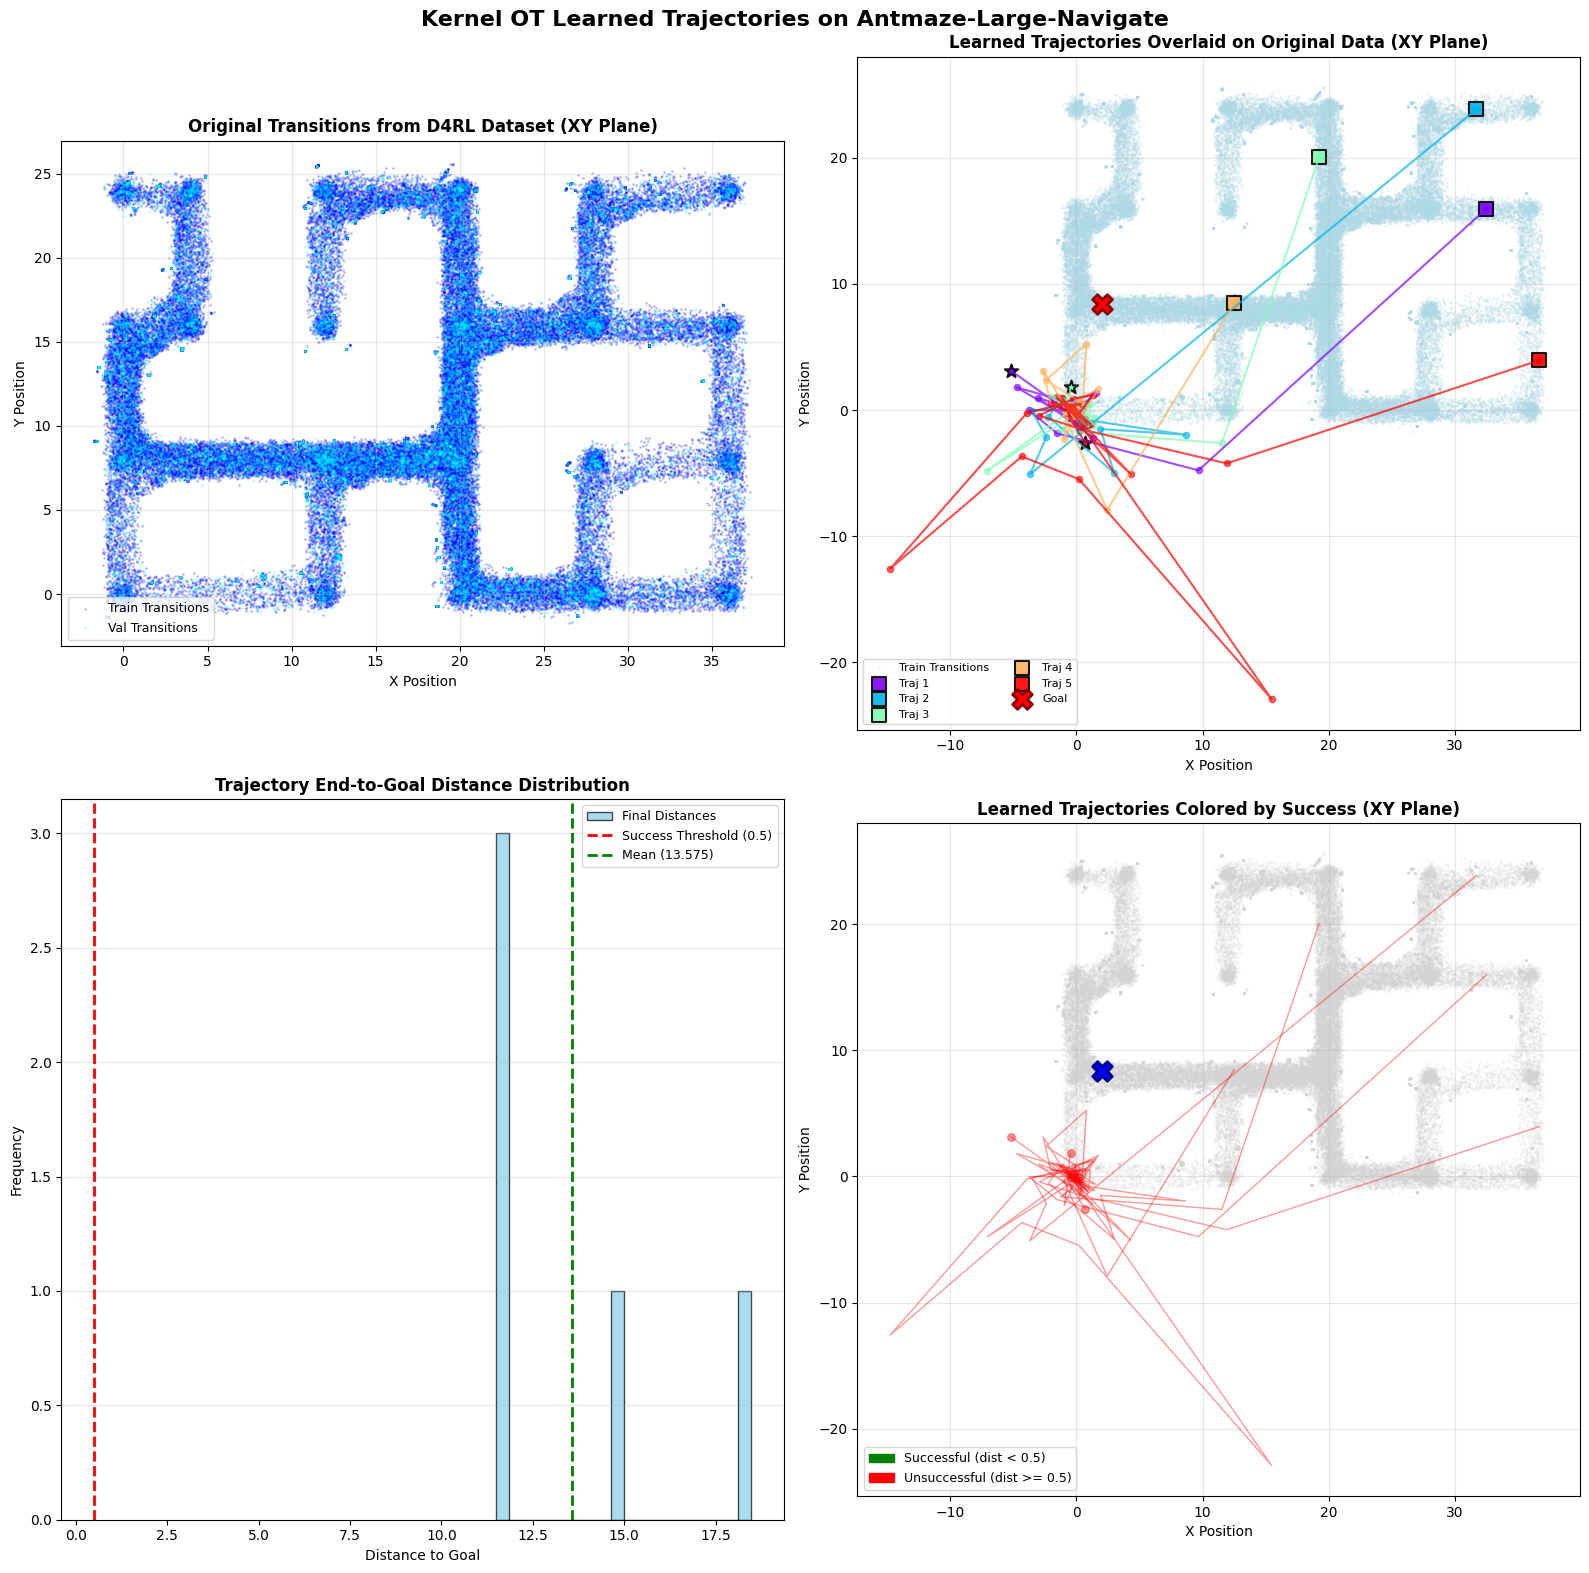

⚠ Could not create maze overlay (environment structure not accessible)

✓ Visualization complete!


In [34]:
"""
Step 8: Visualize Learned Trajectories on D4RL Antmaze Maze with Original Data
- Load original antmaze environment
- Plot maze structure and allowed regions
- Overlay learned trajectories on top
- Highlight initial/goal positions
"""
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
import os

logger.log("\n[Step 8] Trajectory Visualization on D4RL Antmaze Maze")
logger.log("="*80)

# Load the antmaze environment to get the maze structure
try:
    import gym
    env = gym.make("antmaze-large-navigate-v0")
    env.reset()
    
    # Get maze structure if available
    if hasattr(env.unwrapped, 'maze_map'):
        maze = env.unwrapped.maze_map
    elif hasattr(env.unwrapped, 'maze'):
        maze = env.unwrapped.maze
    else:
        # Alternative: try to access from the environment directly
        maze = None
        logger.log("Warning: Could not access maze structure directly")
    
    logger.log(f"✓ Antmaze environment loaded successfully")
    if maze is not None:
        logger.log(f"  Maze shape: {maze.shape}")
    
except Exception as e:
    logger.log(f"Error loading environment: {e}")
    maze = None
    env = None

# Create a comprehensive visualization figure
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle('Kernel OT Learned Trajectories on Antmaze-Large-Navigate', fontsize=16, fontweight='bold')

# ============================================================================
# Plot 1: XY Plane with Original Trajectories from Dataset
# ============================================================================
ax = axes[0, 0]
ax.set_title('Original Transitions from D4RL Dataset (XY Plane)', fontsize=12, fontweight='bold')

# Plot all original transitions as scatter
if 's_train' in locals():
    xy_train = s_train[:, :2].cpu().numpy()
    ax.scatter(xy_train[:, 0], xy_train[:, 1], c='blue', s=1, alpha=0.2, label='Train Transitions')
    logger.log(f"✓ Plotted {len(xy_train)} training transitions")

if 's_val' in locals():
    xy_val = s_val[:, :2].cpu().numpy()
    ax.scatter(xy_val[:, 0], xy_val[:, 1], c='cyan', s=1, alpha=0.2, label='Val Transitions')
    logger.log(f"✓ Plotted {len(xy_val)} validation transitions")

ax.set_xlabel('X Position', fontsize=10)
ax.set_ylabel('Y Position', fontsize=10)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# ============================================================================
# Plot 2: Learned Trajectories Overlay on Original Data
# ============================================================================
ax = axes[0, 1]
ax.set_title('Learned Trajectories Overlaid on Original Data (XY Plane)', fontsize=12, fontweight='bold')

# Plot original transitions as background
if 's_train' in locals():
    ax.scatter(xy_train[:, 0], xy_train[:, 1], c='lightblue', s=1, alpha=0.15, label='Train Transitions')

# Plot learned trajectories
if 'trajectories' in locals() and len(trajectories) > 0:
    colors_traj = plt.cm.rainbow(np.linspace(0, 1, len(trajectories)))
    
    for idx, (traj, color) in enumerate(zip(trajectories[:20], colors_traj[:20])):  # Plot first 20 for clarity
        traj_xy = np.array(traj)[:, :2]
        # Plot trajectory line
        ax.plot(traj_xy[:, 0], traj_xy[:, 1], color=color, linewidth=1.5, alpha=0.7)
        # Plot trajectory points
        ax.scatter(traj_xy[:, 0], traj_xy[:, 1], color=color, s=20, alpha=0.6, marker='o')
        # Mark start and end
        ax.scatter(traj_xy[0, 0], traj_xy[0, 1], color=color, s=100, marker='s', edgecolors='black', linewidth=1.5, alpha=0.9, label=f'Traj {idx+1}' if idx < 5 else '')
        ax.scatter(traj_xy[-1, 0], traj_xy[-1, 1], color=color, s=100, marker='*', edgecolors='black', linewidth=1.5, alpha=0.9)
    
    logger.log(f"✓ Plotted {min(20, len(trajectories))} learned trajectories")

# Mark goal position
if 'GOAL_STATE' in locals():
    goal_xy = GOAL_STATE[:2].cpu().numpy()
    ax.scatter(goal_xy[0], goal_xy[1], color='red', s=200, marker='X', edgecolors='darkred', linewidth=2, label='Goal', zorder=5)
    logger.log(f"✓ Marked goal position at {goal_xy}")

ax.set_xlabel('X Position', fontsize=10)
ax.set_ylabel('Y Position', fontsize=10)
ax.legend(loc='best', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# ============================================================================
# Plot 3: Trajectory Success Analysis
# ============================================================================
ax = axes[1, 0]
ax.set_title('Trajectory End-to-Goal Distance Distribution', fontsize=12, fontweight='bold')

if 'final_distances' in locals() and len(final_distances) > 0:
    # Histogram of final distances
    ax.hist(final_distances, bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Final Distances')
    
    # Mark success threshold
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Success Threshold (0.5)')
    
    # Mark mean
    ax.axvline(x=np.mean(final_distances), color='green', linestyle='--', linewidth=2, label=f'Mean ({np.mean(final_distances):.3f})')
    
    logger.log(f"✓ Final distances range: [{np.min(final_distances):.4f}, {np.max(final_distances):.4f}]")
    logger.log(f"  Mean: {np.mean(final_distances):.4f}, Median: {np.median(final_distances):.4f}")

ax.set_xlabel('Distance to Goal', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

# ============================================================================
# Plot 4: Trajectory Quality Metrics (colored by success)
# ============================================================================
ax = axes[1, 1]
ax.set_title('Learned Trajectories Colored by Success (XY Plane)', fontsize=12, fontweight='bold')

# Plot original transitions as background
if 's_train' in locals():
    ax.scatter(xy_train[:, 0], xy_train[:, 1], c='lightgray', s=1, alpha=0.1, label='Train Transitions')

# Plot learned trajectories colored by success
if 'trajectories' in locals() and len(trajectories) > 0:
    success_threshold = 0.5
    
    for idx, traj in enumerate(trajectories[:50]):  # Plot first 50 for clarity
        traj_xy = np.array(traj)[:, :2]
        final_dist = final_distances[idx] if idx < len(final_distances) else np.inf
        
        # Color: green if successful, red if not
        color = 'green' if final_dist < success_threshold else 'red'
        alpha = 0.8 if final_dist < success_threshold else 0.4
        
        ax.plot(traj_xy[:, 0], traj_xy[:, 1], color=color, linewidth=1, alpha=alpha)
        ax.scatter(traj_xy[-1, 0], traj_xy[-1, 1], color=color, s=30, alpha=alpha, marker='o')
    
    logger.log(f"✓ Plotted {min(50, len(trajectories))} learned trajectories colored by success")
    
    # Add legend for success/failure
    successful_patch = patches.Patch(color='green', label='Successful (dist < 0.5)')
    unsuccessful_patch = patches.Patch(color='red', label='Unsuccessful (dist >= 0.5)')
    ax.legend(handles=[successful_patch, unsuccessful_patch], loc='best', fontsize=9)

# Mark goal position
if 'GOAL_STATE' in locals():
    goal_xy = GOAL_STATE[:2].cpu().numpy()
    ax.scatter(goal_xy[0], goal_xy[1], color='blue', s=200, marker='X', edgecolors='darkblue', linewidth=2, label='Goal', zorder=5)

ax.set_xlabel('X Position', fontsize=10)
ax.set_ylabel('Y Position', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()

# Save the comprehensive visualization
traj_viz_comprehensive_path = os.path.join(OUTPUT_DIR, 'learned_trajectories_comprehensive.png')
plt.savefig(traj_viz_comprehensive_path, dpi=150, bbox_inches='tight')
logger.log(f"✓ Comprehensive visualization saved: {traj_viz_comprehensive_path}")

plt.show()

# ============================================================================
# Create a detailed maze-overlay visualization if environment structure available
# ============================================================================
if env is not None and maze is not None:
    fig, ax = plt.subplots(figsize=(14, 14))
    
    ax.set_title('Learned Trajectories on Antmaze-Large-Navigate Maze', fontsize=14, fontweight='bold')
    
    # Plot maze structure
    # Antmaze maze typically has walls (black) and open space (white)
    # maze_map is usually 1 for walls, 0 for free space
    ax.imshow(maze, cmap='Greys', origin='lower', alpha=0.3, extent=[0, maze.shape[1]*0.1, 0, maze.shape[0]*0.1])
    
    # Plot original transitions
    if 's_train' in locals():
        ax.scatter(xy_train[:, 0], xy_train[:, 1], c='cyan', s=2, alpha=0.1, label='Dataset Transitions')
    
    # Plot learned trajectories
    if 'trajectories' in locals() and len(trajectories) > 0:
        colors_traj = plt.cm.tab20(np.arange(len(trajectories[:20])) % 20)
        
        for idx, (traj, color) in enumerate(zip(trajectories[:20], colors_traj)):
            traj_xy = np.array(traj)[:, :2]
            ax.plot(traj_xy[:, 0], traj_xy[:, 1], color=color, linewidth=2, alpha=0.7, marker='o', markersize=4)
        
        logger.log(f"✓ Plotted learned trajectories over maze")
    
    # Mark goal
    if 'GOAL_STATE' in locals():
        goal_xy = GOAL_STATE[:2].cpu().numpy()
        ax.scatter(goal_xy[0], goal_xy[1], color='red', s=300, marker='X', edgecolors='darkred', linewidth=2.5, label='Goal', zorder=10)
    
    ax.set_xlabel('X Position', fontsize=11)
    ax.set_ylabel('Y Position', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.2)
    ax.set_aspect('equal')
    
    traj_viz_maze_path = os.path.join(OUTPUT_DIR, 'learned_trajectories_on_maze.png')
    plt.savefig(traj_viz_maze_path, dpi=150, bbox_inches='tight')
    logger.log(f"✓ Maze overlay visualization saved: {traj_viz_maze_path}")
    
    plt.show()
else:
    logger.log("⚠ Could not create maze overlay (environment structure not accessible)")

logger.log("\n✓ Visualization complete!")
logger.log("="*80)